<a href="https://colab.research.google.com/github/lexiaylin/examen-final-IA/blob/main/1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# + Generacion del Modelo



In [1]:
!git clone https://github.com/openai/shap-e.git

fatal: destination path 'shap-e' already exists and is not an empty directory.


In [2]:
%cd shap-e

/content/shap-e


In [3]:
!pip install -e .

Obtaining file:///content/shap-e
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-install-2gbxfr6e/clip_fb950f46f06d4df0ad9a1b9844e7f144
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-install-2gbxfr6e/clip_fb950f46f06d4df0ad9a1b9844e7f144
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Attempting uninstall: shap-e
    Found existing installation: shap-e 0.0.0
    Uninstalling shap-e-0.0.0:
      Successfully uninstalled shap-e-0.0.0
  Running setup.py develop for shap-e


In [4]:
import torch

from shap_e.diffusion.sample import sample_latents
from shap_e.diffusion.gaussian_diffusion import diffusion_from_config
from shap_e.models.download import load_model, load_config
from shap_e.util.notebooks import create_pan_cameras, decode_latent_images, gif_widget

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
xm = load_model('transmitter', device=device)
model = load_model('text300M', device=device)
diffusion = diffusion_from_config(load_config('diffusion'))

/content/shap-e/shap_e/models/nn/checkpoint.py:31: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd
/content/shap-e/shap_e/models/nn/checkpoint.py:43: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  @custom_bwd
/content/shap-e/shap_e/models/nn/checkpoint.py:61: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd
/content/shap-e/shap_e/models/nn/checkpoint.py:86: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  @custom_bwd


In [7]:
batch_size = 2
guidance_scale = 15.0
prompt = "dog" #  Prompt - obj a generar

latents = sample_latents(
    batch_size=batch_size,
    model=model,
    diffusion=diffusion,
    guidance_scale=guidance_scale,
    model_kwargs=dict(texts=[prompt] * batch_size),
    progress=True,
    clip_denoised=True,
    use_fp16=True,
    use_karras=True,
    karras_steps=64,
    sigma_min=1e-3,
    sigma_max=160,
    s_churn=0,
)

  0%|          | 0/64 [00:00<?, ?it/s]

# Modelo para Blender


In [8]:
render_mode = 'nerf' # puedes cambiar el tipo de render a 'stf'
size = 128 # este es el tamaño del render; entre mas alto el valor mas tiempo tarda el render.

cameras = create_pan_cameras(size, device)
for i, latent in enumerate(latents):
    images = decode_latent_images(xm, latent, cameras, rendering_mode=render_mode)
    display(gif_widget(images))


HTML(value='<img src="data:image/gif;base64,R0lGODlhgACAAIcAAPHu7O7r6evo5efm4uTi3uHf2t7e2N3c1tvZ1NnZ1NjX0djW0N…

HTML(value='<img src="data:image/gif;base64,R0lGODlhgACAAIcAAMXFw768ury7ur25ubi3tri1tLaysrW0sLCyrrGvra6tq6+rqq…

In [9]:
# Codigo #9 - Descarga tu modelo 3D! :))
# Example of saving the latents as meshes.
from shap_e.util.notebooks import decode_latent_mesh

for i, latent in enumerate(latents):
    t = decode_latent_mesh(xm, latent).tri_mesh()
    with open(f'mesh_{i}.ply', 'wb') as f: # nombre del archivo - Formato Stanford (.ply)
        t.write_ply(f)
    with open(f'mesh_{i}.obj', 'w') as f: # nombre del archivo - Formato OBJ (.obj)
        t.write_obj(f)

/content/shap-e/shap_e/models/stf/renderer.py:286: UserWarning: exception rendering with PyTorch3D: No module named 'pytorch3d'
  warnings.warn(f"exception rendering with PyTorch3D: {exc}")
/content/shap-e/shap_e/models/stf/renderer.py:287: UserWarning: falling back on native PyTorch renderer, which does not support full gradients
  warnings.warn(


## K-Meands (no supervisado)



Agrupa obstáculos cercanos en clusters para simplificar el estado del agente (ej: "obstáculo más cercano en cluster 1").

Agrupar esferas con K-Means

In [10]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

# Generar obstáculos aleatorios
np.random.seed(42)
num_obstaculos = 20
obstaculos = np.random.rand(num_obstaculos, 2) * 2.5  # Posiciones (x, y)

In [11]:
# Aplicar K-Means para agrupar
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, n_init=10)
labels = kmeans.fit_predict(obstaculos)
centros = kmeans.cluster_centers_

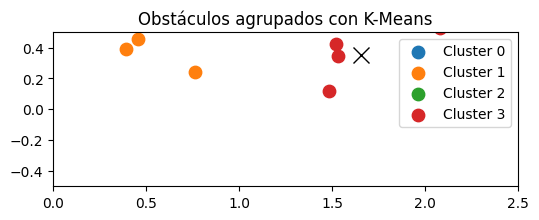

In [12]:
# Visualizar los clusters
fig, ax = plt.subplots(figsize=(6, 2))
for i in range(num_clusters):
    cluster = obstaculos[labels == i]
    ax.scatter(cluster[:, 0], cluster[:, 1], label=f'Cluster {i}', s=80)
    ax.plot(centros[i][0], centros[i][1], 'kx', markersize=12)

plt.legend()
plt.title("Obstáculos agrupados con K-Means")
ax.set_xlim(0, 2.5)
ax.set_ylim(-0.5, 0.5)
plt.show()

Tomar decisiones basadas en los clusters
Aquí simulamos una trayectoria donde el modelo 3D esquiva obstáculos más cercanos por cluster, en lugar de reaccionar individualmente a cada esfera:

In [13]:
trayectoria = []
pos = np.array([0.0, 0.0])
velocidad = 0.05
trayectoria.append(pos.copy())

for _ in range(50):
    pos[0] += velocidad

    # Verifica por cada cluster cuál obstáculo está más cerca
    for i in range(num_clusters):
        cluster_obsts = obstaculos[labels == i]
        distancias = np.linalg.norm(cluster_obsts - pos, axis=1)
        cercano = cluster_obsts[np.argmin(distancias)]

        if np.linalg.norm(cercano - pos) < 0.25:
            pos[1] += 0.1 if pos[1] <= 0 else -0.1
            break

    trayectoria.append(pos.copy())


Visualizar la trayectoria del modelo esquivando por clusters

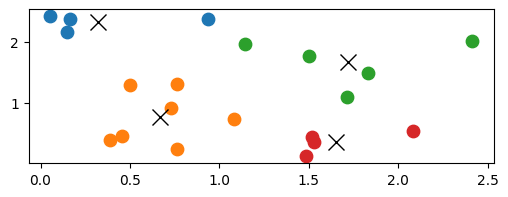

In [14]:
trayectoria = np.array(trayectoria)
fig, ax = plt.subplots(figsize=(6, 2))

# Mostrar obstáculos y clusters
for i in range(num_clusters):
    cluster = obstaculos[labels == i]
    ax.scatter(cluster[:, 0], cluster[:, 1], s=80, label=f'C{i}')
    ax.plot(centros[i][0], centros[i][1], 'kx', markersize=12)

In [15]:
print("Trayectoria:", trayectoria)
print("Shape:", trayectoria.shape)

Trayectoria: [[0.   0.  ]
 [0.05 0.  ]
 [0.1  0.  ]
 [0.15 0.  ]
 [0.2  0.  ]
 [0.25 0.  ]
 [0.3  0.  ]
 [0.35 0.  ]
 [0.4  0.  ]
 [0.45 0.  ]
 [0.5  0.  ]
 [0.55 0.  ]
 [0.6  0.  ]
 [0.65 0.  ]
 [0.7  0.  ]
 [0.75 0.1 ]
 [0.8  0.  ]
 [0.85 0.  ]
 [0.9  0.  ]
 [0.95 0.  ]
 [1.   0.  ]
 [1.05 0.  ]
 [1.1  0.  ]
 [1.15 0.  ]
 [1.2  0.  ]
 [1.25 0.  ]
 [1.3  0.1 ]
 [1.35 0.  ]
 [1.4  0.1 ]
 [1.45 0.  ]
 [1.5  0.1 ]
 [1.55 0.  ]
 [1.6  0.1 ]
 [1.65 0.  ]
 [1.7  0.1 ]
 [1.75 0.1 ]
 [1.8  0.1 ]
 [1.85 0.1 ]
 [1.9  0.1 ]
 [1.95 0.1 ]
 [2.   0.1 ]
 [2.05 0.1 ]
 [2.1  0.1 ]
 [2.15 0.1 ]
 [2.2  0.1 ]
 [2.25 0.1 ]
 [2.3  0.1 ]
 [2.35 0.1 ]
 [2.4  0.1 ]
 [2.45 0.1 ]
 [2.5  0.1 ]]
Shape: (51, 2)


In [16]:
ax.set_xlim(0, 2.5)
ax.set_ylim(-0.5, 0.5)


(-0.5, 0.5)

In [17]:
ax.set_xlim(min(trayectoria[:,0]) - 0.1, max(trayectoria[:,0]) + 0.1)
ax.set_ylim(min(trayectoria[:,1]) - 0.1, max(trayectoria[:,1]) + 0.1)


(-0.1, 0.2)

In [18]:
plt.show(block=True)

## SAM (Segment Anything)



SAM para segmentar obstáculos en renders 2D del entorno (desde la perspectiva del agente).

Convierte las máscaras de SAM en posiciones 3D relativas.

Generar un render 2D del entorno desde la cámara del agente
Esto puede ser una vista desde el frente del modelo, mostrando las esferas:

In [19]:
from PIL import Image
import matplotlib.pyplot as plt
from io import BytesIO

vistas = []

for pos in trayectoria:
    fig, ax = plt.subplots(figsize=(3, 1.5))
    for ox, oy in obstaculos:
        circ = plt.Circle((ox, oy), 0.1, color='red')
        ax.add_patch(circ)
    ax.plot(pos[0], pos[1], 'bo')  # posición del agente
    ax.set_xlim(0, 2.5)
    ax.set_ylim(-0.5, 0.5)
    ax.axis('off')
    buf = BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    img = Image.open(buf).convert("RGB")
    vistas.append(np.array(img))
    plt.close()


Aplicar SAM para segmentar obstáculos desde la imagen
Puedes usar el Segment Anything de Meta cargado en Colab. Aquí simplificamos asumiendo que tienes una instancia predictor de SAM configurada (si no, te puedo ayudar a configurarla también).

In [20]:
from sklearn.decomposition import PCA

# Aplanar imágenes y reducir dimensión
imagenes_flat = [img.flatten() for img in vistas]
pca = PCA(n_components=10)
embeddings = pca.fit_transform(imagenes_flat)


In [21]:
from sklearn.cluster import KMeans

num_clusters = 5
kmeans_vis = KMeans(n_clusters=num_clusters, n_init=10)
labels_vis = kmeans_vis.fit_predict(embeddings)


In [22]:
# Simular una política basada en clusters visuales
acciones = []

for i, estado in enumerate(labels_vis):
    if estado == 0:
        accion = "adelante"
    elif estado == 1:
        accion = "esquivar izquierda"
    elif estado == 2:
        accion = "esquivar derecha"
    else:
        accion = "mantener dirección"
    acciones.append(accion)

# Mostrar decisiones
for i in range(10):
    print(f"Paso {i}: Estado visual {labels_vis[i]} → Acción: {acciones[i]}")


Paso 0: Estado visual 2 → Acción: esquivar derecha
Paso 1: Estado visual 2 → Acción: esquivar derecha
Paso 2: Estado visual 2 → Acción: esquivar derecha
Paso 3: Estado visual 2 → Acción: esquivar derecha
Paso 4: Estado visual 2 → Acción: esquivar derecha
Paso 5: Estado visual 1 → Acción: esquivar izquierda
Paso 6: Estado visual 1 → Acción: esquivar izquierda
Paso 7: Estado visual 1 → Acción: esquivar izquierda
Paso 8: Estado visual 1 → Acción: esquivar izquierda
Paso 9: Estado visual 1 → Acción: esquivar izquierda


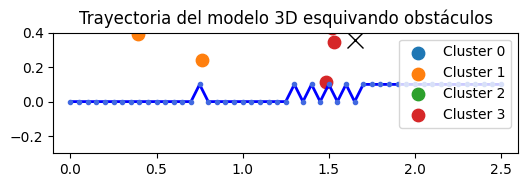

In [24]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(6, 2))

for i in range(len(centros)):
    cluster = obstaculos[labels == i]
    ax.scatter(cluster[:, 0], cluster[:, 1], s=80, label=f'Cluster {i}')
    ax.plot(centros[i][0], centros[i][1], 'kx', markersize=12)

# Trayectoria
ax.plot(trayectoria[:, 0], trayectoria[:, 1], color='blue', linewidth=2)
ax.plot(trayectoria[:, 0], trayectoria[:, 1], 'o', color='royalblue', markersize=3)

ax.set_title("Trayectoria del modelo 3D esquivando obstáculos")
ax.set_xlim(min(trayectoria[:, 0]) - 0.1, max(trayectoria[:, 0]) + 0.1)
ax.set_ylim(min(trayectoria[:, 1]) - 0.3, max(trayectoria[:, 1]) + 0.3)
ax.set_aspect('equal')
ax.legend()
plt.show()


In [28]:
with open(f'mesh_0.obj', 'w') as f:
    t.write_obj(f)


In [29]:
import pandas as pd

df = pd.DataFrame(trayectoria, columns=["x", "y"])
df["z"] = 0  # plano horizontal
df.to_csv("trayectoria.csv", index=False)


In [26]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image
from io import BytesIO
import numpy as np
import trimesh

In [30]:
# En Colab, exporta las posiciones como .csv
pd.DataFrame(obstaculos, columns=["x", "y"]).to_csv("obstaculos.csv", index=False)


In [31]:
from google.colab import drive
import os

# Montar Drive
drive.mount('/content/drive')

# Crear carpeta de exportación
base_path = '/content/drive/MyDrive/shap-e_export'
os.makedirs(base_path, exist_ok=True)
print(f"📁 Carpeta lista en: {base_path}")


Mounted at /content/drive
📁 Carpeta lista en: /content/drive/MyDrive/shap-e_export


In [32]:
!cp mesh_0.obj /content/drive/MyDrive/shap-e_export/perro.obj

In [33]:
import pandas as pd
df_tray = pd.DataFrame(trayectoria, columns=["x", "y"])
df_tray["z"] = 0  # movimiento plano
df_tray.to_csv(f"{base_path}/trayectoria.csv", index=False)

In [34]:
df_obst = pd.DataFrame(obstaculos, columns=["x", "y"])
df_obst["z"] = 0
df_obst.to_csv(f"{base_path}/obstaculos.csv", index=False)

KeyboardInterrupt: 

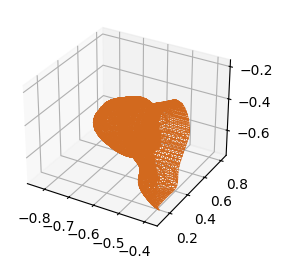

In [27]:
# Cargar el mesh generado por Shap-E (ajusta si usaste otro nombre)
mesh = trimesh.load('mesh_0.obj')

imgs = []

for step in trayectoria:
    fig = plt.figure(figsize=(3, 3))
    ax = fig.add_subplot(projection='3d')

    for face in mesh.faces:
        tri = mesh.vertices[face] + [step[0], step[1], 0]
        x, y, z = tri[:, 0], tri[:, 1], tri[:, 2]
        x = np.append(x, x[0])
        y = np.append(y, y[0])
        z = np.append(z, z[0])
        ax.plot(x, y, z, color='chocolate', linewidth=0.5)

    ax.set_xlim(0, 2.5)
    ax.set_ylim(-0.5, 0.5)
    ax.set_zlim(-0.5, 0.5)
    ax.axis('off')

    buf = BytesIO()
    plt.tight_layout()
    plt.savefig(buf, format='png', transparent=True)
    buf.seek(0)
    imgs.append(Image.open(buf))
    plt.close()


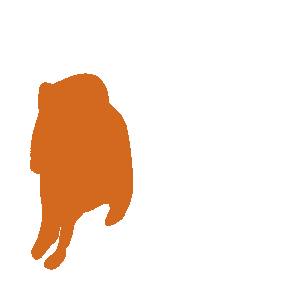

In [35]:
# Guardar y mostrar el GIF
gif_path = "trayectoria_perro_3d.gif"
imgs[0].save(gif_path, save_all=True, append_images=imgs[1:], duration=100, loop=0)

from IPython.display import Image as IPyImage
IPyImage(gif_path)

In [48]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection


In [49]:
mesh = trimesh.load('mesh_0.obj')
imgs = []

# (Opcional) reducir número de pasos
pasos = trayectoria[::5]  # toma 1 de cada 5 para mayor velocidad
for step in pasos:
    fig = plt.figure(figsize=(3, 3))
    ax = fig.add_subplot(projection='3d')

    # Mover el mesh a la posición actual
    verts = mesh.vertices + [step[0], step[1], 0]
    faces = mesh.faces
    triangles = [verts[face] for face in faces]

    # Dibujar con Poly3DCollection (más rápido que ax.plot)
    collection = Poly3DCollection(triangles, facecolors='burlywood', linewidths=0.2, edgecolors='chocolate', alpha=1.0)
    ax.add_collection3d(collection)

    ax.set_xlim(0, 2.5)
    ax.set_ylim(-0.5, 0.5)
    ax.set_zlim(-0.5, 0.5)
    ax.axis('off')

    buf = BytesIO()
    plt.tight_layout()
    plt.savefig(buf, format='png', transparent=True)
    buf.seek(0)
    imgs.append(Image.open(buf))
    plt.close()

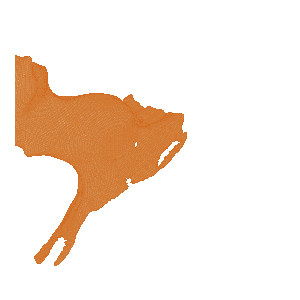

In [50]:
# Guardar y mostrar el GIF
gif_path = "trayectoria_perro_3d.gif"
imgs[0].save(gif_path, save_all=True, append_images=imgs[1:], duration=100, loop=0)

from IPython.display import Image as IPyImage
IPyImage(gif_path)